In [157]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
import talib as ta
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
os.chdir('/Users/shun/PycharmProjects/crypto')

from common.utils import daterange

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)

In [150]:
with open('ml/input/201812250000_201901242359_candles_api_1min.pkl', mode='rb') as f:
    df = pickle.load(f)

In [151]:
df.head()

,open,high,low,close,volume,timestamp
0,47.351,47.45,47.333,47.357,281207.7666,1.545656e+12
1,47.400,47.45,47.382,47.450,422249.3738,1.545656e+12
2,47.457,47.59,47.457,47.555,719997.2811,1.545656e+12
3,47.555,47.65,47.406,47.640,826380.1754,1.545656e+12
4,47.614,47.70,47.614,47.685,714819.1232,1.545656e+12


In [152]:
df.shape

(44770, 6)

In [153]:
candle = df

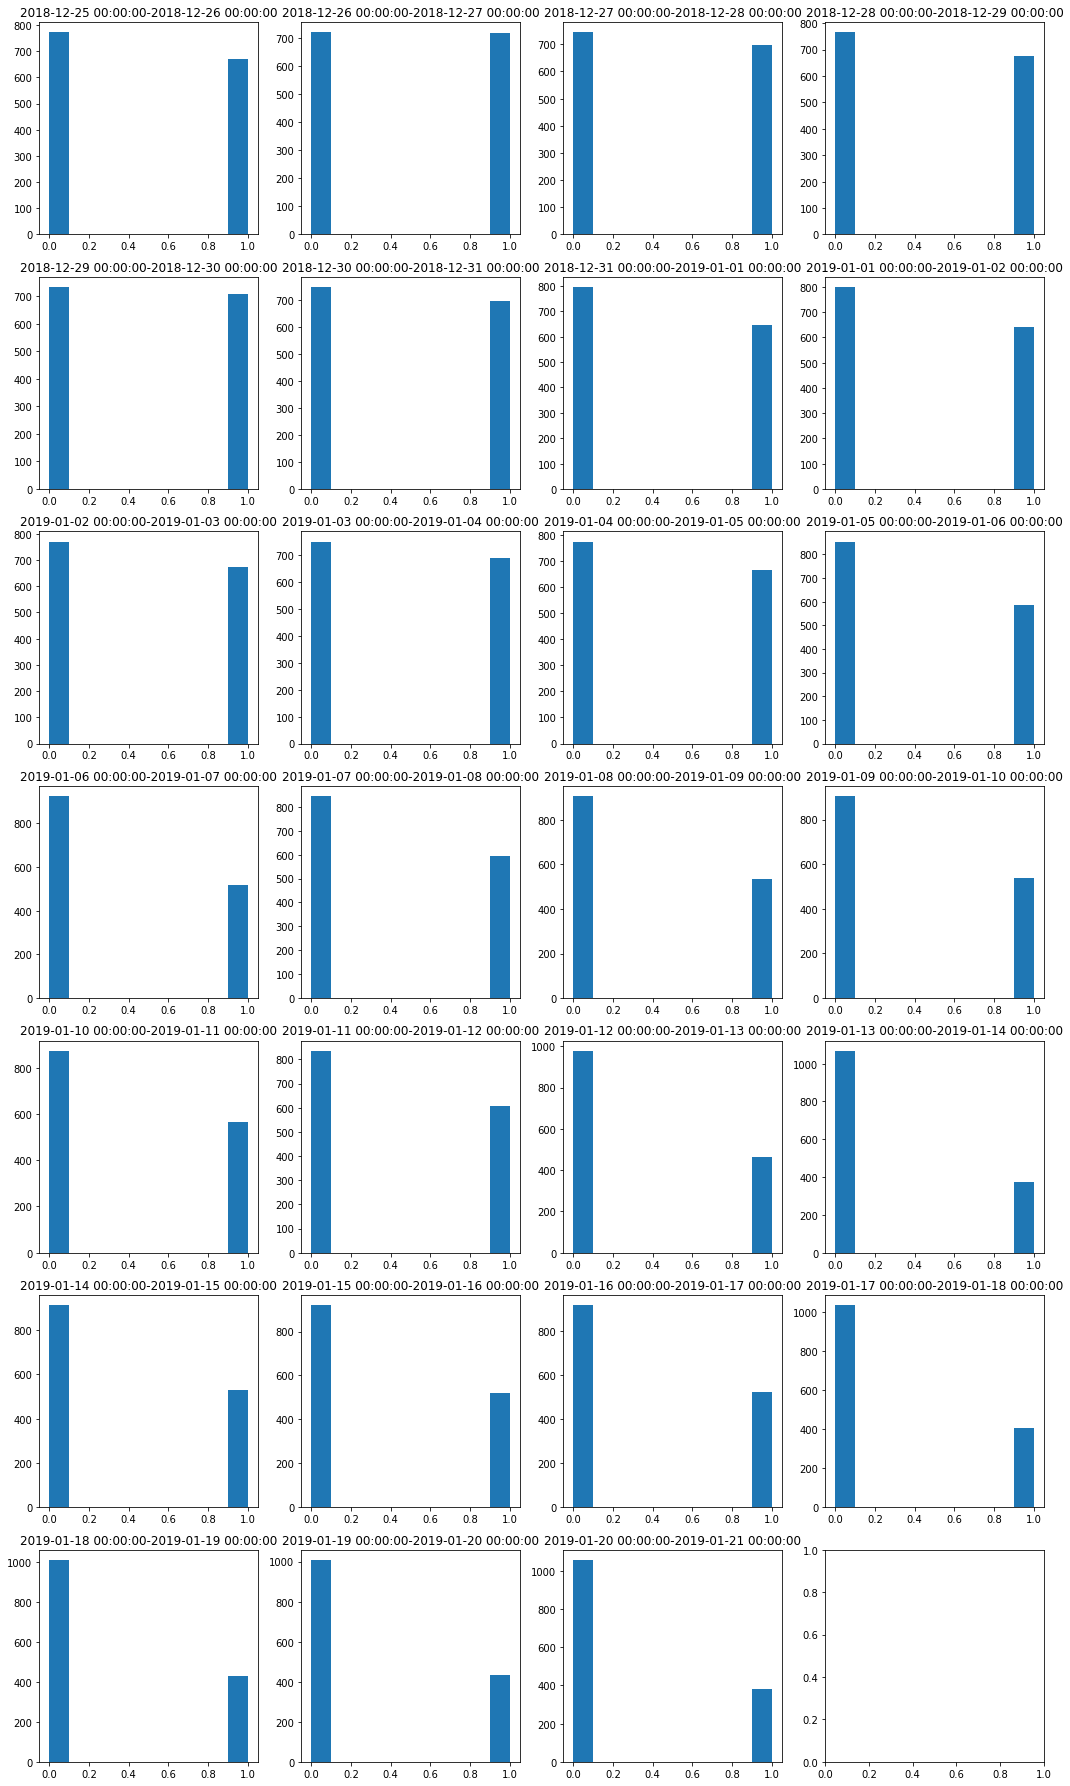

In [180]:
def create_target(df, start_dt, end_dt):
    candles = pd.DataFrame(df, columns=['open', 'high', 'low', 'close', 'volume', 'timestamp'])
    candles.index = candles.timestamp.map(lambda x: datetime.fromtimestamp(x / 1000))
    target = pd.Series(np.where(-candles.close.diff(-1) > 0, 1, 0), index=candles.index)
    target = target.loc[(target.index >= start_dt) & (target.index <= end_dt)]
    return target

start_dt = datetime.strptime('2018-12-25 00:00:00', '%Y-%m-%d %H:%M:%S')
end_dt = datetime.strptime('2019-01-21 00:00:00', '%Y-%m-%d %H:%M:%S')

fig, ax = plt.subplots(7, 4, figsize=(18, 32))
y = -1
for i, d in enumerate(daterange(start_dt, end_dt)):
    #print('{}-{}'.format(d, d + timedelta(days=1)))
    target = create_target(candle, d, d + timedelta(days=1))
    x = i % 4
    if x == 0:
        y += 1
    ax[y][x].hist(target)
    ax[y][x].set_title('{}-{}'.format(d, d + timedelta(days=1)))

In [161]:
from scipy.stats import linregress

def calc_highests(high, lower=2):
    '''
    天井を求める
    '''
    X = np.arange(len(high))
    # 回帰直線より大きい値（初期値は高値）
    highests = pd.Series(high.reset_index(drop=True), index=X)
    while len(highests) > lower:
        # highestsを元に回帰直線を求める
        reg = linregress(x = highests.index, y = highests)
        reg_line = reg[0] * highests.index + reg[1]
        # highestsを更新する
        tmp = highests.loc[highests > reg_line]
        if len(tmp) == len(highests):
            return None
        highests = tmp
    if len(highests) <= 1:
        return None
    return highests

def calc_lowests(low, lower=2):
    '''
    底値を求める
    '''
    X = np.arange(len(low))
    # 回帰直線より大きい値（初期値は高値）
    lowests = pd.Series(low.reset_index(drop=True), index=X)
    while len(lowests) > lower:
        # highestsを元に回帰直線を求める
        reg = linregress(x=lowests.index, y=lowests)
        reg_line = reg[0] * lowests.index + reg[1]
        # highestsを更新する
        tmp = lowests.loc[lowests < reg_line]
        if len(tmp) == len(lowests):
            return None
        lowests = tmp
    if len(lowests) <= 1:
        return None
    return lowests

def calc_trendlines(candle, w_size=100, stride=30):
    results = []
    starts = range(0, len(candle), stride)
    ends = range(w_size, len(candle), stride)
    X = np.arange(len(candle))
    for w_start, w_end in zip(starts, ends):
        # 天井のトレンドライン
        highests = calc_highests(candle.ix[w_start:w_end, 'high'])
        if highests is not None:
            reg = linregress(x=highests.index + w_start, y=highests)
            #results.append((reg_highest[0], reg_highest[1], trendline))
            results.append({'a': reg[0], 'b': reg[1], 'data': reg[0] * X + reg[1]})
        # 底値のトレンドライン
        lowests = calc_lowests(candle.ix[w_start:w_end, 'low'])
        if lowests is not None:
            reg = linregress(x=lowests.index + w_start, y=lowests)
            results.append({'a': reg[0], 'b': reg[1], 'data': reg[0] * X + reg[1]})
    return results

def calc_trendline_feature(candle, trendlines):
    curr_high = candle.iloc[-1].high
    curr_low = candle.iloc[-1].low

    features = {}
    min_diff_high = 9999
    min_diff_low = 9999
    for trendline in trendlines:
        curr_trend = trendline['data'][-1]
        diff_high = curr_trend - curr_high
        diff_low = curr_trend - curr_low

        if min_diff_high > np.abs(diff_high):
            features['high_a'] = trendline['a']
            features['high_b'] = trendline['b']
            features['high_diff'] = diff_high
            min_diff_high = np.abs(diff_high)
        if min_diff_low > np.abs(diff_low):
            features['low_a'] = trendline['a']
            features['low_b'] = trendline['b']
            features['low_diff'] = diff_low
            min_diff_low = np.abs(diff_low)
    return features

In [122]:
from datetime import timedelta
def datetimerange(start, end):
    for n in range(int((end - start).total_seconds() / 60)):
        yield start + timedelta(minutes=n)

In [128]:
candle.index = candle.timestamp.apply(lambda x: datetime.fromtimestamp(x / 1000))

In [146]:
candle.index[0]

Timestamp('2019-01-07 21:50:00')

In [148]:
#from common.utils import daterange

#start_dt = datetime.strptime(start_dt, '%Y-%m-%d %H:%M:%S')
#end_dt = datetime.strptime(end_dt, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=1)

for dt in datetimerange(candle.index[0], candle.index[-1] + timedelta(minutes=1)):
    print('{}-{}'.format(dt - timedelta(minutes=130), dt))
    
    start_dt = (dt - timedelta(minutes=130)).strftime('%Y-%m-%d %H:%M:%S')
    end_dt = dt.strftime('%Y-%m-%d %H:%M:%S')
    tmp = candle.loc[(start_dt <= candle.index) & (candle.index <= end_dt)]
    #for w_size, stride in [(15, 5), (30, 10), (60, 10), (120, 10)]:
    for w_size, stride in [(120, 10)]:
        trendlines = calc_trendlines(tmp, w_size, stride)
        if len(trendlines) == 0:
            continue
        trendline_feature = calc_trendline_feature(tmp, trendlines)
        
        #print('{} {} {}'.format(trendline_feature['high_a'], trendline_feature['high_b'], trendline_feature['high_diff']))
        
        features.loc[features.index == end_dt, 'trendline_high_a_{}'.format(w_size)] = trendline_feature['high_a']
        features.loc[features.index == end_dt, 'trendline_high_b_{}'.format(w_size)] = trendline_feature['high_b']
        features.loc[features.index == end_dt, 'trendline_high_diff_{}'.format(w_size)] = trendline_feature['high_diff']
        features.loc[features.index == end_dt, 'trendline_low_a_{}'.format(w_size)] = trendline_feature['low_a']
        features.loc[features.index == end_dt, 'trendline_low_b_{}'.format(w_size)] = trendline_feature['low_b']
        features.loc[features.index == end_dt, 'trendline_low_diff_{}'.format(w_size)] = trendline_feature['low_diff']

2019-01-07 19:40:00-2019-01-07 21:50:00
2019-01-07 19:41:00-2019-01-07 21:51:00
2019-01-07 19:42:00-2019-01-07 21:52:00
2019-01-07 19:43:00-2019-01-07 21:53:00
2019-01-07 19:44:00-2019-01-07 21:54:00
2019-01-07 19:45:00-2019-01-07 21:55:00
2019-01-07 19:46:00-2019-01-07 21:56:00
2019-01-07 19:47:00-2019-01-07 21:57:00
2019-01-07 19:48:00-2019-01-07 21:58:00
2019-01-07 19:49:00-2019-01-07 21:59:00
2019-01-07 19:50:00-2019-01-07 22:00:00
2019-01-07 19:51:00-2019-01-07 22:01:00
2019-01-07 19:52:00-2019-01-07 22:02:00
2019-01-07 19:53:00-2019-01-07 22:03:00
2019-01-07 19:54:00-2019-01-07 22:04:00
2019-01-07 19:55:00-2019-01-07 22:05:00
2019-01-07 19:56:00-2019-01-07 22:06:00
2019-01-07 19:57:00-2019-01-07 22:07:00
2019-01-07 19:58:00-2019-01-07 22:08:00
2019-01-07 19:59:00-2019-01-07 22:09:00
2019-01-07 20:00:00-2019-01-07 22:10:00
2019-01-07 20:01:00-2019-01-07 22:11:00
2019-01-07 20:02:00-2019-01-07 22:12:00
2019-01-07 20:03:00-2019-01-07 22:13:00
2019-01-07 20:04:00-2019-01-07 22:14:00


2019-01-09 05:07:00-2019-01-09 07:17:00
2019-01-09 05:08:00-2019-01-09 07:18:00
2019-01-09 05:09:00-2019-01-09 07:19:00
2019-01-09 05:10:00-2019-01-09 07:20:00
2019-01-09 05:11:00-2019-01-09 07:21:00
2019-01-09 05:12:00-2019-01-09 07:22:00
2019-01-09 05:13:00-2019-01-09 07:23:00
2019-01-09 05:14:00-2019-01-09 07:24:00
2019-01-09 05:15:00-2019-01-09 07:25:00
2019-01-09 05:16:00-2019-01-09 07:26:00
2019-01-09 05:17:00-2019-01-09 07:27:00
2019-01-09 05:18:00-2019-01-09 07:28:00
2019-01-09 05:19:00-2019-01-09 07:29:00
2019-01-09 05:20:00-2019-01-09 07:30:00
2019-01-09 05:21:00-2019-01-09 07:31:00
2019-01-09 05:22:00-2019-01-09 07:32:00
2019-01-09 05:23:00-2019-01-09 07:33:00
2019-01-09 05:24:00-2019-01-09 07:34:00
2019-01-09 05:25:00-2019-01-09 07:35:00
2019-01-09 05:26:00-2019-01-09 07:36:00
2019-01-09 05:27:00-2019-01-09 07:37:00
2019-01-09 05:28:00-2019-01-09 07:38:00
2019-01-09 05:29:00-2019-01-09 07:39:00
2019-01-09 05:30:00-2019-01-09 07:40:00
2019-01-09 05:31:00-2019-01-09 07:41:00


2019-01-10 06:06:00-2019-01-10 08:16:00
2019-01-10 06:07:00-2019-01-10 08:17:00
2019-01-10 06:08:00-2019-01-10 08:18:00
2019-01-10 06:09:00-2019-01-10 08:19:00
2019-01-10 06:10:00-2019-01-10 08:20:00
2019-01-10 06:11:00-2019-01-10 08:21:00
2019-01-10 06:12:00-2019-01-10 08:22:00
2019-01-10 06:13:00-2019-01-10 08:23:00
2019-01-10 06:14:00-2019-01-10 08:24:00
2019-01-10 06:15:00-2019-01-10 08:25:00
2019-01-10 06:16:00-2019-01-10 08:26:00
2019-01-10 06:17:00-2019-01-10 08:27:00
2019-01-10 06:18:00-2019-01-10 08:28:00
2019-01-10 06:19:00-2019-01-10 08:29:00
2019-01-10 06:20:00-2019-01-10 08:30:00
2019-01-10 06:21:00-2019-01-10 08:31:00
2019-01-10 06:22:00-2019-01-10 08:32:00
2019-01-10 06:23:00-2019-01-10 08:33:00
2019-01-10 06:24:00-2019-01-10 08:34:00
2019-01-10 06:25:00-2019-01-10 08:35:00
2019-01-10 06:26:00-2019-01-10 08:36:00
2019-01-10 06:27:00-2019-01-10 08:37:00
2019-01-10 06:28:00-2019-01-10 08:38:00
2019-01-10 06:29:00-2019-01-10 08:39:00
2019-01-10 06:30:00-2019-01-10 08:40:00


2019-01-11 08:41:00-2019-01-11 10:51:00
2019-01-11 08:42:00-2019-01-11 10:52:00
2019-01-11 08:43:00-2019-01-11 10:53:00
2019-01-11 08:44:00-2019-01-11 10:54:00
2019-01-11 08:45:00-2019-01-11 10:55:00
2019-01-11 08:46:00-2019-01-11 10:56:00
2019-01-11 08:47:00-2019-01-11 10:57:00
2019-01-11 08:48:00-2019-01-11 10:58:00
2019-01-11 08:49:00-2019-01-11 10:59:00
2019-01-11 08:50:00-2019-01-11 11:00:00
2019-01-11 08:51:00-2019-01-11 11:01:00
2019-01-11 08:52:00-2019-01-11 11:02:00
2019-01-11 08:53:00-2019-01-11 11:03:00
2019-01-11 08:54:00-2019-01-11 11:04:00
2019-01-11 08:55:00-2019-01-11 11:05:00
2019-01-11 08:56:00-2019-01-11 11:06:00
2019-01-11 08:57:00-2019-01-11 11:07:00
2019-01-11 08:58:00-2019-01-11 11:08:00
2019-01-11 08:59:00-2019-01-11 11:09:00
2019-01-11 09:00:00-2019-01-11 11:10:00
2019-01-11 09:01:00-2019-01-11 11:11:00
2019-01-11 09:02:00-2019-01-11 11:12:00
2019-01-11 09:03:00-2019-01-11 11:13:00
2019-01-11 09:04:00-2019-01-11 11:14:00
2019-01-11 09:05:00-2019-01-11 11:15:00


2019-01-12 16:25:00-2019-01-12 18:35:00
2019-01-12 16:26:00-2019-01-12 18:36:00
2019-01-12 16:27:00-2019-01-12 18:37:00
2019-01-12 16:28:00-2019-01-12 18:38:00
2019-01-12 16:29:00-2019-01-12 18:39:00
2019-01-12 16:30:00-2019-01-12 18:40:00
2019-01-12 16:31:00-2019-01-12 18:41:00
2019-01-12 16:32:00-2019-01-12 18:42:00
2019-01-12 16:33:00-2019-01-12 18:43:00
2019-01-12 16:34:00-2019-01-12 18:44:00
2019-01-12 16:35:00-2019-01-12 18:45:00
2019-01-12 16:36:00-2019-01-12 18:46:00
2019-01-12 16:37:00-2019-01-12 18:47:00
2019-01-12 16:38:00-2019-01-12 18:48:00
2019-01-12 16:39:00-2019-01-12 18:49:00
2019-01-12 16:40:00-2019-01-12 18:50:00
2019-01-12 16:41:00-2019-01-12 18:51:00
2019-01-12 16:42:00-2019-01-12 18:52:00
2019-01-12 16:43:00-2019-01-12 18:53:00
2019-01-12 16:44:00-2019-01-12 18:54:00
2019-01-12 16:45:00-2019-01-12 18:55:00
2019-01-12 16:46:00-2019-01-12 18:56:00
2019-01-12 16:47:00-2019-01-12 18:57:00
2019-01-12 16:48:00-2019-01-12 18:58:00
2019-01-12 16:49:00-2019-01-12 18:59:00


2019-01-14 01:45:00-2019-01-14 03:55:00
2019-01-14 01:46:00-2019-01-14 03:56:00
2019-01-14 01:47:00-2019-01-14 03:57:00
2019-01-14 01:48:00-2019-01-14 03:58:00
2019-01-14 01:49:00-2019-01-14 03:59:00
2019-01-14 01:50:00-2019-01-14 04:00:00
2019-01-14 01:51:00-2019-01-14 04:01:00
2019-01-14 01:52:00-2019-01-14 04:02:00
2019-01-14 01:53:00-2019-01-14 04:03:00
2019-01-14 01:54:00-2019-01-14 04:04:00
2019-01-14 01:55:00-2019-01-14 04:05:00
2019-01-14 01:56:00-2019-01-14 04:06:00
2019-01-14 01:57:00-2019-01-14 04:07:00
2019-01-14 01:58:00-2019-01-14 04:08:00
2019-01-14 01:59:00-2019-01-14 04:09:00
2019-01-14 02:00:00-2019-01-14 04:10:00
2019-01-14 02:01:00-2019-01-14 04:11:00
2019-01-14 02:02:00-2019-01-14 04:12:00
2019-01-14 02:03:00-2019-01-14 04:13:00
2019-01-14 02:04:00-2019-01-14 04:14:00
2019-01-14 02:05:00-2019-01-14 04:15:00
2019-01-14 02:06:00-2019-01-14 04:16:00
2019-01-14 02:07:00-2019-01-14 04:17:00
2019-01-14 02:08:00-2019-01-14 04:18:00
2019-01-14 02:09:00-2019-01-14 04:19:00


2019-01-15 10:09:00-2019-01-15 12:19:00
2019-01-15 10:10:00-2019-01-15 12:20:00
2019-01-15 10:11:00-2019-01-15 12:21:00
2019-01-15 10:12:00-2019-01-15 12:22:00
2019-01-15 10:13:00-2019-01-15 12:23:00
2019-01-15 10:14:00-2019-01-15 12:24:00
2019-01-15 10:15:00-2019-01-15 12:25:00
2019-01-15 10:16:00-2019-01-15 12:26:00
2019-01-15 10:17:00-2019-01-15 12:27:00
2019-01-15 10:18:00-2019-01-15 12:28:00
2019-01-15 10:19:00-2019-01-15 12:29:00
2019-01-15 10:20:00-2019-01-15 12:30:00
2019-01-15 10:21:00-2019-01-15 12:31:00
2019-01-15 10:22:00-2019-01-15 12:32:00
2019-01-15 10:23:00-2019-01-15 12:33:00
2019-01-15 10:24:00-2019-01-15 12:34:00
2019-01-15 10:25:00-2019-01-15 12:35:00
2019-01-15 10:26:00-2019-01-15 12:36:00
2019-01-15 10:27:00-2019-01-15 12:37:00
2019-01-15 10:28:00-2019-01-15 12:38:00
2019-01-15 10:29:00-2019-01-15 12:39:00
2019-01-15 10:30:00-2019-01-15 12:40:00
2019-01-15 10:31:00-2019-01-15 12:41:00
2019-01-15 10:32:00-2019-01-15 12:42:00
2019-01-15 10:33:00-2019-01-15 12:43:00


2019-01-16 12:04:00-2019-01-16 14:14:00
2019-01-16 12:05:00-2019-01-16 14:15:00
2019-01-16 12:06:00-2019-01-16 14:16:00
2019-01-16 12:07:00-2019-01-16 14:17:00
2019-01-16 12:08:00-2019-01-16 14:18:00
2019-01-16 12:09:00-2019-01-16 14:19:00
2019-01-16 12:10:00-2019-01-16 14:20:00
2019-01-16 12:11:00-2019-01-16 14:21:00
2019-01-16 12:12:00-2019-01-16 14:22:00
2019-01-16 12:13:00-2019-01-16 14:23:00
2019-01-16 12:14:00-2019-01-16 14:24:00
2019-01-16 12:15:00-2019-01-16 14:25:00
2019-01-16 12:16:00-2019-01-16 14:26:00
2019-01-16 12:17:00-2019-01-16 14:27:00
2019-01-16 12:18:00-2019-01-16 14:28:00
2019-01-16 12:19:00-2019-01-16 14:29:00
2019-01-16 12:20:00-2019-01-16 14:30:00
2019-01-16 12:21:00-2019-01-16 14:31:00
2019-01-16 12:22:00-2019-01-16 14:32:00
2019-01-16 12:23:00-2019-01-16 14:33:00
2019-01-16 12:24:00-2019-01-16 14:34:00
2019-01-16 12:25:00-2019-01-16 14:35:00
2019-01-16 12:26:00-2019-01-16 14:36:00
2019-01-16 12:27:00-2019-01-16 14:37:00
2019-01-16 12:28:00-2019-01-16 14:38:00


2019-01-17 21:15:00-2019-01-17 23:25:00
2019-01-17 21:16:00-2019-01-17 23:26:00
2019-01-17 21:17:00-2019-01-17 23:27:00
2019-01-17 21:18:00-2019-01-17 23:28:00
2019-01-17 21:19:00-2019-01-17 23:29:00
2019-01-17 21:20:00-2019-01-17 23:30:00
2019-01-17 21:21:00-2019-01-17 23:31:00
2019-01-17 21:22:00-2019-01-17 23:32:00
2019-01-17 21:23:00-2019-01-17 23:33:00
2019-01-17 21:24:00-2019-01-17 23:34:00
2019-01-17 21:25:00-2019-01-17 23:35:00
2019-01-17 21:26:00-2019-01-17 23:36:00
2019-01-17 21:27:00-2019-01-17 23:37:00
2019-01-17 21:28:00-2019-01-17 23:38:00
2019-01-17 21:29:00-2019-01-17 23:39:00
2019-01-17 21:30:00-2019-01-17 23:40:00
2019-01-17 21:31:00-2019-01-17 23:41:00
2019-01-17 21:32:00-2019-01-17 23:42:00
2019-01-17 21:33:00-2019-01-17 23:43:00
2019-01-17 21:34:00-2019-01-17 23:44:00
2019-01-17 21:35:00-2019-01-17 23:45:00
2019-01-17 21:36:00-2019-01-17 23:46:00
2019-01-17 21:37:00-2019-01-17 23:47:00
2019-01-17 21:38:00-2019-01-17 23:48:00
2019-01-17 21:39:00-2019-01-17 23:49:00


2019-01-18 22:23:00-2019-01-19 00:33:00
2019-01-18 22:24:00-2019-01-19 00:34:00
2019-01-18 22:25:00-2019-01-19 00:35:00
2019-01-18 22:26:00-2019-01-19 00:36:00
2019-01-18 22:27:00-2019-01-19 00:37:00
2019-01-18 22:28:00-2019-01-19 00:38:00
2019-01-18 22:29:00-2019-01-19 00:39:00
2019-01-18 22:30:00-2019-01-19 00:40:00
2019-01-18 22:31:00-2019-01-19 00:41:00
2019-01-18 22:32:00-2019-01-19 00:42:00
2019-01-18 22:33:00-2019-01-19 00:43:00
2019-01-18 22:34:00-2019-01-19 00:44:00
2019-01-18 22:35:00-2019-01-19 00:45:00
2019-01-18 22:36:00-2019-01-19 00:46:00
2019-01-18 22:37:00-2019-01-19 00:47:00
2019-01-18 22:38:00-2019-01-19 00:48:00
2019-01-18 22:39:00-2019-01-19 00:49:00
2019-01-18 22:40:00-2019-01-19 00:50:00
2019-01-18 22:41:00-2019-01-19 00:51:00
2019-01-18 22:42:00-2019-01-19 00:52:00
2019-01-18 22:43:00-2019-01-19 00:53:00
2019-01-18 22:44:00-2019-01-19 00:54:00
2019-01-18 22:45:00-2019-01-19 00:55:00
2019-01-18 22:46:00-2019-01-19 00:56:00
2019-01-18 22:47:00-2019-01-19 00:57:00


2019-01-20 07:42:00-2019-01-20 09:52:00
2019-01-20 07:43:00-2019-01-20 09:53:00
2019-01-20 07:44:00-2019-01-20 09:54:00
2019-01-20 07:45:00-2019-01-20 09:55:00
2019-01-20 07:46:00-2019-01-20 09:56:00
2019-01-20 07:47:00-2019-01-20 09:57:00
2019-01-20 07:48:00-2019-01-20 09:58:00
2019-01-20 07:49:00-2019-01-20 09:59:00
2019-01-20 07:50:00-2019-01-20 10:00:00
2019-01-20 07:51:00-2019-01-20 10:01:00
2019-01-20 07:52:00-2019-01-20 10:02:00
2019-01-20 07:53:00-2019-01-20 10:03:00
2019-01-20 07:54:00-2019-01-20 10:04:00
2019-01-20 07:55:00-2019-01-20 10:05:00
2019-01-20 07:56:00-2019-01-20 10:06:00
2019-01-20 07:57:00-2019-01-20 10:07:00
2019-01-20 07:58:00-2019-01-20 10:08:00
2019-01-20 07:59:00-2019-01-20 10:09:00
2019-01-20 08:00:00-2019-01-20 10:10:00
2019-01-20 08:01:00-2019-01-20 10:11:00
2019-01-20 08:02:00-2019-01-20 10:12:00
2019-01-20 08:03:00-2019-01-20 10:13:00
2019-01-20 08:04:00-2019-01-20 10:14:00
2019-01-20 08:05:00-2019-01-20 10:15:00
2019-01-20 08:06:00-2019-01-20 10:16:00


2019-01-21 17:02:00-2019-01-21 19:12:00
2019-01-21 17:03:00-2019-01-21 19:13:00
2019-01-21 17:04:00-2019-01-21 19:14:00
2019-01-21 17:05:00-2019-01-21 19:15:00
2019-01-21 17:06:00-2019-01-21 19:16:00
2019-01-21 17:07:00-2019-01-21 19:17:00
2019-01-21 17:08:00-2019-01-21 19:18:00
2019-01-21 17:09:00-2019-01-21 19:19:00
2019-01-21 17:10:00-2019-01-21 19:20:00
2019-01-21 17:11:00-2019-01-21 19:21:00
2019-01-21 17:12:00-2019-01-21 19:22:00
2019-01-21 17:13:00-2019-01-21 19:23:00
2019-01-21 17:14:00-2019-01-21 19:24:00
2019-01-21 17:15:00-2019-01-21 19:25:00
2019-01-21 17:16:00-2019-01-21 19:26:00
2019-01-21 17:17:00-2019-01-21 19:27:00
2019-01-21 17:18:00-2019-01-21 19:28:00
2019-01-21 17:19:00-2019-01-21 19:29:00
2019-01-21 17:20:00-2019-01-21 19:30:00
2019-01-21 17:21:00-2019-01-21 19:31:00
2019-01-21 17:22:00-2019-01-21 19:32:00
2019-01-21 17:23:00-2019-01-21 19:33:00
2019-01-21 17:24:00-2019-01-21 19:34:00
2019-01-21 17:25:00-2019-01-21 19:35:00
2019-01-21 17:26:00-2019-01-21 19:36:00


2019-01-23 02:21:00-2019-01-23 04:31:00
2019-01-23 02:22:00-2019-01-23 04:32:00
2019-01-23 02:23:00-2019-01-23 04:33:00
2019-01-23 02:24:00-2019-01-23 04:34:00
2019-01-23 02:25:00-2019-01-23 04:35:00
2019-01-23 02:26:00-2019-01-23 04:36:00
2019-01-23 02:27:00-2019-01-23 04:37:00
2019-01-23 02:28:00-2019-01-23 04:38:00
2019-01-23 02:29:00-2019-01-23 04:39:00
2019-01-23 02:30:00-2019-01-23 04:40:00
2019-01-23 02:31:00-2019-01-23 04:41:00
2019-01-23 02:32:00-2019-01-23 04:42:00
2019-01-23 02:33:00-2019-01-23 04:43:00
2019-01-23 02:34:00-2019-01-23 04:44:00
2019-01-23 02:35:00-2019-01-23 04:45:00
2019-01-23 02:36:00-2019-01-23 04:46:00
2019-01-23 02:37:00-2019-01-23 04:47:00
2019-01-23 02:38:00-2019-01-23 04:48:00
2019-01-23 02:39:00-2019-01-23 04:49:00
2019-01-23 02:40:00-2019-01-23 04:50:00
2019-01-23 02:41:00-2019-01-23 04:51:00
2019-01-23 02:42:00-2019-01-23 04:52:00
2019-01-23 02:43:00-2019-01-23 04:53:00
2019-01-23 02:44:00-2019-01-23 04:54:00
2019-01-23 02:45:00-2019-01-23 04:55:00


2019-01-24 15:17:00-2019-01-24 17:27:00
2019-01-24 15:18:00-2019-01-24 17:28:00
2019-01-24 15:19:00-2019-01-24 17:29:00
2019-01-24 15:20:00-2019-01-24 17:30:00
2019-01-24 15:21:00-2019-01-24 17:31:00
2019-01-24 15:22:00-2019-01-24 17:32:00
2019-01-24 15:23:00-2019-01-24 17:33:00
2019-01-24 15:24:00-2019-01-24 17:34:00
2019-01-24 15:25:00-2019-01-24 17:35:00
2019-01-24 15:26:00-2019-01-24 17:36:00
2019-01-24 15:27:00-2019-01-24 17:37:00
2019-01-24 15:28:00-2019-01-24 17:38:00
2019-01-24 15:29:00-2019-01-24 17:39:00
2019-01-24 15:30:00-2019-01-24 17:40:00
2019-01-24 15:31:00-2019-01-24 17:41:00
2019-01-24 15:32:00-2019-01-24 17:42:00
2019-01-24 15:33:00-2019-01-24 17:43:00
2019-01-24 15:34:00-2019-01-24 17:44:00
2019-01-24 15:35:00-2019-01-24 17:45:00
2019-01-24 15:36:00-2019-01-24 17:46:00
2019-01-24 15:37:00-2019-01-24 17:47:00
2019-01-24 15:38:00-2019-01-24 17:48:00
2019-01-24 15:39:00-2019-01-24 17:49:00
2019-01-24 15:40:00-2019-01-24 17:50:00
2019-01-24 15:41:00-2019-01-24 17:51:00


In [76]:
high = tmp.iloc[-1].high
low = tmp.iloc[-1].low
trendline_features = []
for trendline in trendlines:
    trendline['diff_high'] = trendline['data'][-1] - high
    trendline['diff_low'] = trendline['data'][-1] - low
    trendline_features.append(trendline)
trendline_features = sorted(trendline_features, key=lambda x: np.abs(x['diff_high']))

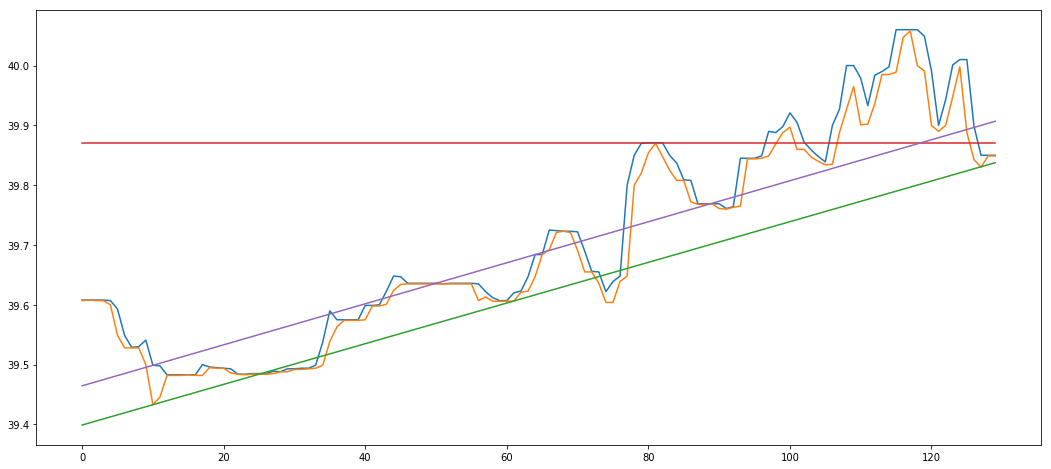

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(tmp.high.values)
ax.plot(tmp.low.values)
ax.plot(trendline_features[0]['data'])
ax.plot(trendline_features[1]['data'])
ax.plot(trendline_features[2]['data'])

#ax.set_ylim(39.4, 40.1)

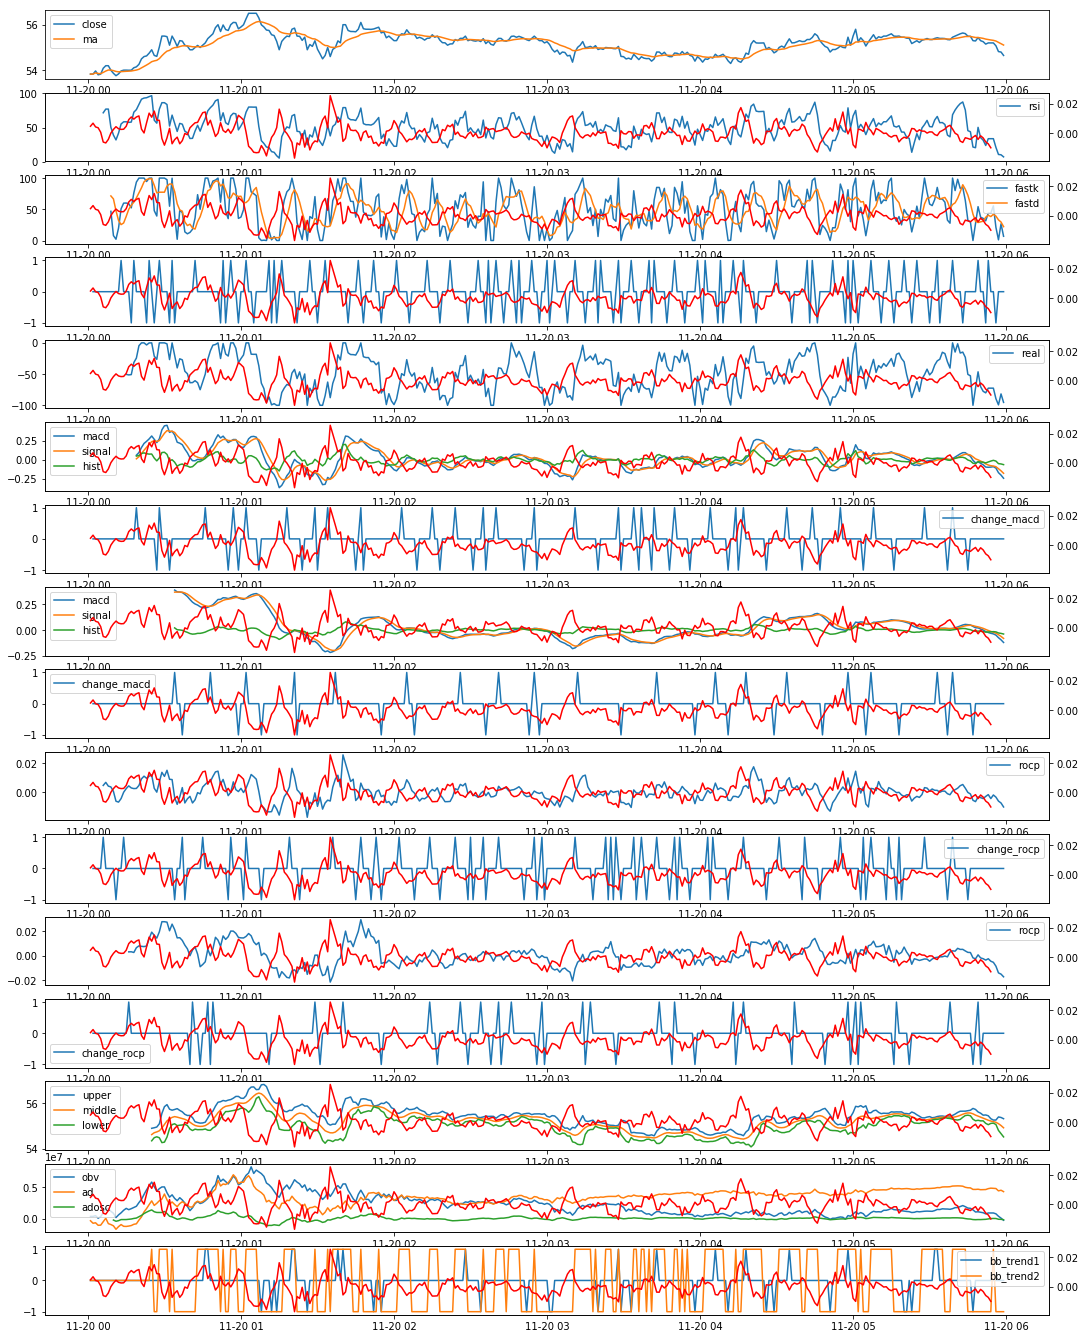

In [9]:
fig, ax = plt.subplots(16, 1, figsize=(18, 24))

ax[0].plot(candle.close)
ax[0].plot(ma)
ax[0].legend(['close', 'ma'])

ax[1].plot(rsi)
ax[1].legend(['rsi'])
ax2 = ax[1].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[2].plot(fastk)
ax[2].plot(fastd)
ax[2].legend(['fastk', 'fastd'])
ax2 = ax[2].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[3].plot(change_stockf)
ax2 = ax[3].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[4].plot(real)
ax[4].legend(['real'])
ax2 = ax[4].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[5].plot(macd_s)
ax[5].plot(macdsignal_s)
ax[5].plot(macdhist_s)
ax[5].legend(['macd', 'signal', 'hist'])
ax2 = ax[5].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[6].plot(change_macd_s)
ax[6].legend(['change_macd'])
ax2 = ax[6].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[7].plot(macd_l)
ax[7].plot(macdsignal_l)
ax[7].plot(macdhist_l)
ax[7].legend(['macd', 'signal', 'hist'])
ax2 = ax[7].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[8].plot(change_macd_l)
ax[8].legend(['change_macd'])
ax2 = ax[8].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[9].plot(rocp_s)
ax[9].legend(['rocp'])
ax2 = ax[9].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[10].plot(change_rocp_s)
ax[10].legend(['change_rocp'])
ax2 = ax[10].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[11].plot(rocp_l)
ax[11].legend(['rocp'])
ax2 = ax[11].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[12].plot(change_rocp_l)
ax[12].legend(['change_rocp'])
ax2 = ax[12].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[13].plot(bb_upper)
ax[13].plot(bb_middle)
ax[13].plot(bb_lower)
ax[13].legend(['upper', 'middle', 'lower'])
ax2 = ax[13].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[14].plot(obv)
ax[14].plot(ad)
ax[14].plot(adosc)
ax[14].legend(['obv', 'ad', 'adosc'])
ax2 = ax[14].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')

ax[15].plot(bb_trend1)
ax[15].plot(bb_trend2)
ax[15].legend(['bb_trend1', 'bb_trend2'])
ax2 = ax[15].twinx()  # 2つのプロットを関連付ける
ax2.plot(target, color='r')